Importing libraries and loading the train and test file

In [377]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tr = pd.read_csv("Desktop/housePricesData/train.csv",index_col = 0)
test_housePrices = pd.read_csv("Desktop/housePricesData/test.csv",index_col = 0)

tr.shape

(1460, 80)

So there are 80 features and 1460 instances.

Lets see how many features are categorical and numerical.

In [378]:
print ("no. of numerical columns = ", end="")
print (tr.select_dtypes(include = 'number').shape[1])
print ("no. of categorical columns = ", end="")
print (tr.select_dtypes(include = 'object').shape[1])

no. of numerical columns = 37
no. of categorical columns = 43


**Digging deep into the numerical columns**

Lets see if the numerical columns have any missing values

In [379]:
tr.select_dtypes(include = 'number').isna().any()

MSSubClass       False
LotFrontage       True
LotArea          False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
MasVnrArea        True
BsmtFinSF1       False
BsmtFinSF2       False
BsmtUnfSF        False
TotalBsmtSF      False
1stFlrSF         False
2ndFlrSF         False
LowQualFinSF     False
GrLivArea        False
BsmtFullBath     False
BsmtHalfBath     False
FullBath         False
HalfBath         False
BedroomAbvGr     False
KitchenAbvGr     False
TotRmsAbvGrd     False
Fireplaces       False
GarageYrBlt       True
GarageCars       False
GarageArea       False
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
MoSold           False
YrSold           False
SalePrice        False
dtype: bool

These are the 3 (out of 37) numerical columns with missing data: LotFrontage, MasVnrArea, GarageYrBlt

We are going to see the correlation of each feature to each other

In [380]:
#plt.subplots(figsize=(12, 9))
#sns.heatmap(tr.corr())

**Observations from the heatmap: **  We can see that OverallQual, GrLivArea have a correlation of 0.79 and 0.70, respectively, with the SalePrice. 

Furthermore, GarageCars & GarageArea are correlated with eachother so we'll take only one of these features (that is correlated highly with SalePrice) and omit the other to negate collinearity. Therefore, we will include GarageCars that has a correlation of 0.64 with SalePrice. 

We also see that TotalBsmtSF and 1stFirSF is correlated to each other and has the same correlation coefficient to the SalePrice.

To make our job easy, we'll only include numerical features whose correlation coefficient is greater than the threshold we set.

In [381]:
threshold = 0.45
corr_number = pd.DataFrame([tr[i].corr(tr.SalePrice) for i in tr.select_dtypes(include = 'number')],
             index = tr.select_dtypes(include = 'number').columns, columns = ['SalePrice'])
corr_number.loc[corr_number.SalePrice > threshold,:].index

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object')

Lets plot graphs to see the relationship between these features and SalePrice clearly.

,SalePrice,GrLivArea
Id,,
524,184750,4676
692,755000,4316
1183,745000,4476
1299,160000,5642


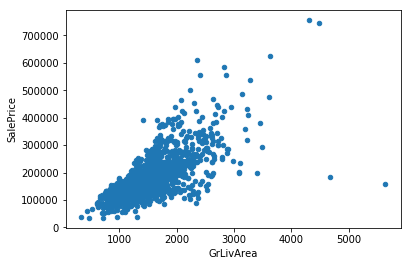

In [382]:
#sns.boxplot(x=tr.GrLivArea)
tr.plot(x="GrLivArea",y ="SalePrice", kind="scatter")
#immediately we see that the 2 points on the lower right are outliers so we should delete them.
tr.loc[tr.GrLivArea > 4000,["SalePrice","GrLivArea"]]

,SalePrice,GarageArea
Id,,
582,253293,1390
826,385000,1220
1062,81000,1248
1191,168000,1356
1299,160000,1418


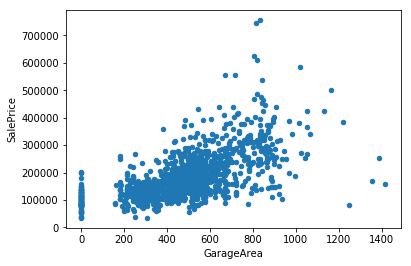

In [383]:
tr.plot(x="GarageArea",y ="SalePrice", kind="scatter")
tr.loc[tr.GarageArea > 1200,["SalePrice","GarageArea"]]

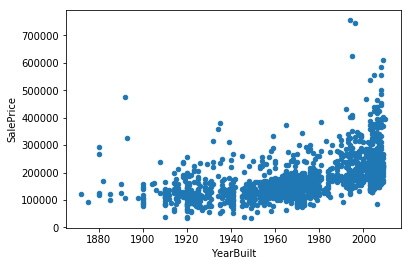

In [384]:
tr.plot(x="YearBuilt",y ="SalePrice", kind="scatter")

Note: index 1299 seems like an outlier in both plots

In [385]:
tr.drop(axis=0, index=1298, inplace=True)

# Lets tackle Categorical features

In [386]:
cat_f = tr.select_dtypes(include="object")
cat_f.head()
cat_f.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

We are going to see if any of the categorical features have any missing values.

In [387]:
missing_percent = pd.DataFrame(cat_f.isna().mean(axis=0)*100, columns=["Missing %"])
total_missing = pd.DataFrame(cat_f.isna().sum(axis=0),columns=["Total Missing"])
cat_misstable = pd.concat([missing_percent,total_missing],axis = 1)
cat_misstable.loc[cat_misstable['Total Missing'] > 0,:].sort_values(by = "Missing %", ascending = False)

,Missing %,Total Missing
PoolQC,99.520219,1452
MiscFeature,96.298835,1405
Alley,93.762851,1368
Fence,80.740233,1178
FireplaceQu,47.224126,689
GarageType,5.551748,81
GarageFinish,5.551748,81
GarageQual,5.551748,81
GarageCond,5.551748,81
BsmtExposure,2.604524,38


Most of these NA values represent information; the NA in Alley means no alley access.
Therefore, we are going to fill these NA values with appropriate information.

In [388]:
tr.Alley.fillna("no", inplace = True)

for i in cat_f.columns:
    print(tr.groupby(by=tr[i]).SalePrice.mean())
    print()

MSZoning
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126253.774194
Name: SalePrice, dtype: float64

Street
Grvl    130190.500000
Pave    181158.845836
Name: SalePrice, dtype: float64

Alley
Grvl    122219.080000
Pave    168000.585366
no      183483.894737
Name: SalePrice, dtype: float64

LotShape
IR1    206101.665289
IR2    239833.365854
IR3    216036.500000
Reg    164781.609307
Name: SalePrice, dtype: float64

LandContour
Bnk    143104.079365
HLS    231533.940000
Low    203661.111111
Lvl    180214.421374
Name: SalePrice, dtype: float64

Utilities
AllPub    180979.043896
NoSeWa    137500.000000
Name: SalePrice, dtype: float64

LotConfig
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176973.193149
Name: SalePrice, dtype: float64

LandSlope
Gtl    179985.732802
Mod    196734.138462
Sev    204379.230769
Name: SalePrice, dtype: float64

Neighborhood
Blmngtn    

In [389]:
for df in [tr,test_housePrices]:
    for i in ['BsmtQual','BsmtCond']:
        df[i].fillna('no',inplace= True)
        #print (df.BsmtQual.value_counts())

In [390]:
for df in [tr,test_housePrices]:
    for i in ['ExterQual','ExterCond','BsmtQual','BsmtCond']:
        df[i] = df[i].map({'TA':3, 'Gd':2, 'Ex':1, 'Po':5, 'Fa':4,'no': 5})

In [391]:
tr.MSZoning.isna().value_counts() #no missing values in training set
tr.MSZoning.value_counts()

test_housePrices.MSZoning.isna().value_counts() #4 missing values

#sns.boxplot(x="MSZoning",y="SalePrice",data=tr)

for df in [tr,test_housePrices]:
    df.MSZoning = df.MSZoning.map({'RL':1,'FV':1,'RM':2,'RH':2,'C (all)':3})
    
test_housePrices.MSZoning.fillna(2, inplace=True)
test_housePrices.MSZoning.isna().value_counts()

False    1459
Name: MSZoning, dtype: int64

In [392]:
# tr.MSSubClass.isna().value_counts()
# for df in [tr,test_housePrices]:
#     df['MSSubClass'] = df.MSSubClass.map({30:1,45:1,180:1,160:2,190:2,90:2,50:2,85:2,40:2,20:3,75:3,120:3,80:4,70:4,60:5,150:2})

Features to include when training

In [393]:
feature_includedNum = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','GrLivArea', 
                       'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'TotRmsAbvGrd', 'Fireplaces', 'MSSubClass']
feature_includedCat = ['ExterQual','ExterCond','BsmtQual']

features = feature_includedNum + feature_includedCat

Drop the unwanted features from training and test sets. GarageCars and TotalBsmtSF has one missing value in test set

In [394]:
train_target = tr["SalePrice"]

training_set = tr.loc[:,features]

testing_set = test_housePrices.loc[:,features]

#filling in missing values
#testing_set.GarageCars.fillna(np.ceil(testing_set.GarageCars.mean()), inplace=True) 
#testing_set.TotalBsmtSF.fillna(np.ceil(testing_set.TotalBsmtSF.mean()), inplace=True)

testing_set.isna().any()

OverallQual     False
YearBuilt       False
YearRemodAdd    False
TotalBsmtSF     False
GrLivArea       False
FullBath        False
TotRmsAbvGrd    False
GarageCars      False
TotRmsAbvGrd    False
Fireplaces      False
MSSubClass      False
ExterQual       False
ExterCond       False
BsmtQual        False
KitchenQual     False
dtype: bool

# Training and Prediction using Gradient Boosting

In [395]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

#Training 3000
gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                         min_samples_leaf=15, min_samples_split=10, loss='huber').fit(training_set.values,train_target)
#Predictions
predictions_gb = gb.predict(testing_set.values)
frame_gb = pd.DataFrame(predictions_gb, columns = ['SalePrice'], index=testing_set.index)
#writing
frame_gb.to_csv('Desktop/gb11.csv')